In [ ]:
#import Mi_Library as MI

                         #load standard libraries and set graphing styles
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from enum import Enum
import  struct 
import os
from array import array
from scipy.stats import trim_mean
from scipy.optimize import minimize
from sklearn.mixture import GaussianMixture
from matplotlib.colors import Normalize 
from skimage.filters import threshold_multiotsu
import numpy as np
import matplotlib.pyplot as plt

#load standard libraries and set graphing styles
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import  struct 
import os
from array import array
from scipy.stats import trim_mean
from scipy.optimize import minimize
from sklearn.mixture import GaussianMixture
from matplotlib.colors import Normalize 
from skimage.filters import threshold_multiotsu
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt


large = 18
med = 18
small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (8, 6),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-v0_8-darkgrid')



def loadMI(filename):
    size=os.path.getsize(filename)
    current=[]
    
    baseTime=os.path.getctime(filename)
    distance=[]
    times=[]
    velocity=[]
    distances=[]
    data = array('B')
    isSpectroscopy=False
    bufferLabels = []
    bufferUnits =[]
    bufferDirections = []
    bufferRange=[]
    displayRange = [] 
    chunkLabels = [] 
    displayOffset = []
    parameters = {}
    with open(filename, "rb") as file1:
        # Reading form a file
        d=file1.readline()
        chunks=[]
        while d!='data          BINARY\n' and d!='data          BINARY_32\n':
            d=file1.readline()
            
            d=d.decode('ascii')
            dd=d.strip().split(' ')
            
            if len(dd)>1:
                ddClean =" ".join( [x for x in dd[1:] if x!=' ']).strip() .replace('FALSE','False').replace('TRUE','True')
                 
                try:
                    ddClean=eval(ddClean)
                except:
                    pass
                
                
                parameters[dd[0]]=ddClean
                
            if len(dd)>1 and dd[-1]=='Spectroscopy':
                isSpectroscopy=True
          
            if dd[0]=='bufferLabel':
                bufferLabels.append(" ".join(dd[1:]).strip())
            if dd[0]=='bufferUnit':
                bufferUnits.append(" ".join(dd[1:]).strip())
            if dd[0]=='direction':
                bufferDirections.append(" ".join(dd[1:]).strip())
            if dd[0]=='bufferRange':
                bufferRange.append(float(dd[-1]))
           
            if dd[0]==('DisplayRange'):
                displayRange.append(float(dd[-1]))
            if dd[0]==('DisplayOffset'):
                displayOffset.append(float(dd[-1]))
                
                    
            if  dd[0]==('bias'):
                bias =float(dd[-1]) 
                
            if  d.startswith('chunk'):
                parts = d.split('\t')
                
                dist=float(parts[5])
                time0=float(parts[2])
                time=float(parts[3])
                valueO=float(parts[4])
                label = parts[-1].strip()
                chunks.append({'points':int(parts[1]),
                               'distperpoint':dist, 
                               'timeperpoint':time,
                               'startValue':valueO,
                               'time0':time0,
                               'label':label})

        

        
        loc = file1.tell()
        binarySize =size-loc
        data.fromfile(file1,binarySize )

        if not isSpectroscopy:
            images = {}
            cc=0
            xPixels = parameters['xPixels']
            yPixels = parameters['yPixels']
            for i in range(0,len(bufferLabels)):
                img = np.zeros((xPixels,yPixels))
                 
                for j in range(0,xPixels):
                    for k in range(0,yPixels):
                        img[j,k] = struct.unpack('i', data[cc:cc+4])[0]
                        cc+=4
                        
                 
                images[bufferLabels[i]+ "_" + bufferDirections[i] ]= ({ 'img':img  * bufferRange[i]/2147483648.0,  
                                'label':bufferLabels[i],
                                'unit':bufferUnits[i],
                                'width':parameters['xLength'] * 1e6,
                                'height':parameters['yLength'] * 1e6,
                                'widthUnit' : 'um',
                                'heightUnit' : 'um',
                                'direction':bufferDirections[i]
                               })
            return {'images':images,'parameters':parameters}
        else:
            i=0
            while True:
                    cDist=0
                   
                    for chunk in chunks:
                        chunkDist=[]
                        chunkCurrent=[]
                        
                        if isSpectroscopy:
                            cDist=chunk['startValue']
                            

                        for j in range(0,chunk['points']):
                            try:
                                f=(struct.unpack('<f', data[i:i+4]))
                            except:
                                print(chunkLabels) 
                                curveChunks = [] 
                                for k in range(len(distance)):
                                    curveChunks.append({
                                        'x':np.array(distance[k]),
                                        'y':np.array(current[k]),
                                        'time':np.array(times[k]),
                                        'velocity':velocity[k],
                                        'label':chunkLabels[k]
                                        }
                                                       )
                                
                                curves =   {
                                        'xlabel':bufferLabels[0],
                                        'xunit':bufferUnits[0],
                                        'ylabel':bufferLabels[1],
                                        'yunit':bufferUnits[1],
                                        'data':curveChunks,
                                        'time':np.array(times[k]),
                                        'velocity':np.array(velocity[k]),
                                    }
                                return {'curves':curves,'parameters':parameters}
                            chunkCurrent.append(f)
                            cDist+=chunk['distperpoint']
                            chunkDist.append(cDist)
                            i+=4
                    
                        dist=np.array(chunkDist)
                        if len(dist)>0:
                            chunkLabels.append(chunk['label'])
                            distance.append(dist)
                            current.append(np.array(chunkCurrent).ravel()) 
                            totalTime=len(chunkDist)*chunk['timeperpoint']
                            time= chunk['time0']+ np.linspace(0, totalTime, len(chunkDist))
                        
                            times.append(time )
                            if len(dist)>0:
                                distances.append((dist[0]-dist[-1]))
                                velocity.append((dist[0]-dist[-1])/(time[0]-time[-1]))
                                

def SetPrefix(y):
    y=np.array(y)
    # Determine best unit prefix for current values
    y_abs_max = max(abs(y.min()), abs(y.max()))
    if y_abs_max < 1e-12:
        scale = 1e15
        prefix = 'f'
    if y_abs_max < 1e-9:
        scale = 1e12
        prefix = 'p'
    elif y_abs_max < 1e-6:
        scale = 1e9
        prefix = 'n'
    elif y_abs_max < 1e-3:
        scale = 1e6
        prefix = 'μ'
    elif y_abs_max < 1:
        scale = 1e3
        prefix = 'm'
    else:
        scale = 1
        prefix = ''    
    return scale, prefix

def _SinglePlot(ax, imagePack,     **kwargs):
    
     # Define width and height in micrometers
    if imagePack['widthUnit'] == 'um':
        iWidth = imagePack['width']  *1e-6
    else :
        iWidth = imagePack['width']  
    if imagePack['heightUnit'] == 'um':
        iHeight =imagePack['height'] *1e-6
    else :
        iHeight = imagePack['height']
    
    scaleXY, prefixXY = SetPrefix([iWidth])
    
    dataUnit = imagePack['unit']
    if dataUnit == 'um':
        dataUnit = 'm'
        image = imagePack['img'] * 1e-6
    else:
        image = imagePack['img']
    
    scaleZ, prefixZ = SetPrefix(image.ravel())
    
    if 'title' in kwargs.keys():
        ax.set_title(kwargs['title'], fontsize=12, fontweight='bold')
    else:
        ax.set_title(f'{imagePack['label']} - {imagePack['direction']}', fontsize=12, fontweight='bold')
        
    # Determine normalization range, excluding outliers
    vmin, vmax = np.percentile(image, [1, 99])  # 1st and 99th percentiles
        
    # Display the AFM data
    im = ax.imshow(
        image*scaleZ,
        cmap='afmhot',
        extent=[0, iWidth*scaleXY, 0, iHeight*scaleXY],
        interpolation='nearest',
        norm=Normalize(vmin=vmin*scaleZ, vmax=vmax*scaleZ)  # Normalize with determined range
    )

    # Set ticks and labels
    ax.set_xticks([0, iWidth*scaleXY])
    ax.set_yticks([0, iHeight*scaleXY])
    ax.set_xticklabels(['0', f'{iWidth*scaleXY:.1f}'], fontsize=12, fontweight='bold')
    ax.set_yticklabels(['0', f'{iHeight*scaleXY:.1f}'], fontsize=12, fontweight='bold', rotation='vertical')

    # Set axis labels
    ax.set_xlabel(f'Width ({prefixXY}m)', fontsize=12, fontweight='bold')
    ax.set_ylabel(f'Height ({prefixXY}m)', fontsize=12, fontweight='bold')

    # Add the color bar with the same height as the image
    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    cbar.ax.tick_params(labelsize=12)
    cbar.ax.set_ylabel(f'({prefixZ}{dataUnit})', fontsize=12, fontweight='bold')

    # Remove grid
    ax.grid(False)             


def AFMPlot(  images,  **kwargs):
    
    if isinstance(images, dict)== False:
        raise ValueError("images should be a dictionary loaded with MI.loadMI, or a single image from the dictionary")
        
    showPlot=True
    #if images is a dictionary, extract the image data
    if 'images' in images.keys():
        isMultipleChannels = True
        keys = list(images['images'].keys())
        cols = 2
        rows = int(np.ceil( len(keys)/cols ))
        
        fig, ax = plt.subplots(rows, cols, **kwargs)
    else:
        isMultipleChannels = False
        #check if kwargs already has a figure and axis
        if 'fig' in kwargs.keys() and 'ax' in kwargs.keys():
            fig = kwargs['fig']
            ax = kwargs['ax']
            showPlot=False
        else:
            fig, ax = plt.subplots(1, 1, **kwargs)

    #remove ax from kwargs if it exists
    if 'ax' in kwargs.keys():
        del kwargs['ax']
            
    if isMultipleChannels:
        for i, key in enumerate(keys):
            image = images['images'][key] 
            _SinglePlot(ax[i//2, i%2], image, **kwargs )
    else:
        _SinglePlot(ax, images, **kwargs )
        
    if showPlot:
        fig.tight_layout()
        fig.subplots_adjust(hspace=0.4, wspace=0.4)
        plt.show()
            
class AFMFlatteningMethod(Enum):
    Median = 1 #A basic correction method, based on finding a representative height of each scan line and subtracting it, thus moving the lines to the same height. Here the line median is used as the representative height
    MedianOfDifference = 2#In contrast to shifting a representative height for each line, Median difference shifts the lines so that the median of height differences (between vertical neighbour pixels) becomes zero. Therefore it better preserves large features while it is more sensitive to completely bogus lines.
    Modus = 3 #This method differs from Median only in the quantity used: modus of the height distribution. Of course, the modus is only estimated because only a finite set of heights is avaiable.
    Matching = 4 #This algorithm is somewhat experimental but it may be useful sometimes. It minimizes a certain line difference function that gives more weight to flat areas and less weight to areas with large slopes.
    FacetLevelTilt = 5 #levels data by subtracting a plane similarly to the standard Plane Level function. However, the plane is determined differently: it makes facets of the surface as horizontal as possible. Thus for surfaces with flat horizontal areas it leads to much better results than the standard Plane Level especially if large objects are present.
    PolynomialLine = 6
    TrimmedMean = 7#In trimmed mean given fractions of lowest and highest values are discarded and the remaining data are averaged. For no discarded values the filter is identical to the mean value filter
    TrimmedMeanOfDifference = 8 #This method similarly offers a continuous transition between Median difference and mean value subtraction. It makes zero the trimmed means of height differences (between vertical neighbour pixels). For the maximum possible trimming (0.5) it is equivalent to Median difference. Since the mean difference is the same as the difference of mean values (unlike for medians), for no trimming (0) it is again equivalent to Polynomial with degree 0.
    Terrace = 9        
    PlaneLevel=10 #Plane levelling is usually one of the first functions applied to raw SPM data. The plane is computed from all the image points and is subtracted from the data.
    ThreePoint=11
    
def _trimmed_mean_flattening(topography, trim_ratio=0.1, mask=None):
    """
    Perform trimmed mean of difference flattening on an AFM image.

    Args:
        topography (np.ndarray): Image with topography data.
        trim_ratio (float): Fraction to trim from each end of the data when computing the mean.
        mask (np.ndarray, optional): Boolean mask where 1 indicates good points to use for flattening.

    Returns:
        np.ndarray: Flattened topography image.
    """
    
    # Get image dimensions
    rows, _ = topography.shape
    
    # Create an empty array for the flattened image
    flattened_image = np.zeros_like(topography)
    
    # Process each row by subtracting the trimmed mean
    for i in range(rows):
        row_data = topography[i, :]
        
        # Apply mask if provided
        if mask is not None:
            row_mask = mask[i, :]
            valid_data = row_data[row_mask == 1]
            # If no valid points in this row, use all points
            if len(valid_data) == 0:
                valid_data = row_data
        else:
            valid_data = row_data
            
        # Calculate trimmed mean for each row using only valid data
        row_mean = trim_mean(valid_data, trim_ratio)
        
        # Subtract the mean from each row
        flattened_image[i, :] = row_data - row_mean
    
    return flattened_image            

def trimmed_mean_of_difference_flattening(topography, trim_ratio=0.1, mask=None):
    """
    Perform trimmed mean of difference flattening on an AFM image.
    
    Args:
        topography (dict or np.ndarray): Image with topography data (can be image dict or direct array)
        trim_ratio (float): Fraction to trim from each end of the data when computing the mean.
        mask (np.ndarray, optional): Boolean mask where 1 indicates good points to use for flattening.
        
    Returns:
        dict or np.ndarray: Flattened topography image in the same format as input
    """
    # Extract the image array if a dictionary is provided
    if isinstance(topography, dict) and 'img' in topography:
        img = topography['img'].copy()
        return_dict = True
    else:
        img = topography.copy()
        return_dict = False
    
    # Get image dimensions
    rows, _ = img.shape
    
    # Process each row
    for i in range(rows-1):
        # Calculate row differences
        differences = img[i+1, :] - img[i, :]
        
        # Apply mask if provided
        if mask is not None:
            # Use only points that are valid in both rows
            combined_mask = (mask[i, :] == 1) & (mask[i+1, :] == 1)
            valid_differences = differences[combined_mask]
            # If no valid points, use all differences
            if len(valid_differences) == 0:
                valid_differences = differences
        else:
            valid_differences = differences
            
        # Calculate trimmed mean of differences
        diff_mean = trim_mean(valid_differences, trim_ratio)
        
        # Adjust the next row based on the differences
        img[i+1, :] = img[i+1, :] - diff_mean
    
    # Return in the same format as input
    if return_dict:
        topography['img'] = img
        return topography
    else:
        return img

def planeLevelFlattening(image, exclude_mask=None, mask=None):
    """
    Subtract a fitted plane from an AFM topography image.
    
    Args:
        image (np.ndarray): 2D array of topography data
        exclude_mask (np.ndarray, optional): Boolean mask to exclude regions from plane fitting (deprecated)
        mask (np.ndarray, optional): Boolean mask where 1 indicates good points to use for flattening.
        
    Returns:
        np.ndarray: Flattened image with plane subtracted
    """
    # Create a copy of the input image
    img = image.copy()
    rows, cols = img.shape
    
    # Create coordinate meshgrid
    x, y = np.meshgrid(np.arange(cols), np.arange(rows))
    
    # Flatten the coordinates and image for fitting
    x_flat = x.flatten()
    y_flat = y.flatten()
    z_flat = img.flatten()
    
    # Create design matrix for plane fit: z = ax + by + c
    A = np.column_stack((x_flat, y_flat, np.ones_like(x_flat)))
    
    # If mask is provided, use it to select good points
    if mask is not None:
        mask_flat = mask.flatten()
        A = A[mask_flat == 1]
        z_flat = z_flat[mask_flat == 1]
    # For backward compatibility with exclude_mask
    elif exclude_mask is not None:
        mask_flat = exclude_mask.flatten()
        A = A[~mask_flat]
        z_flat = z_flat[~mask_flat]
    
    # Solve for plane coefficients using least squares
    coeffs, _, _, _ = np.linalg.lstsq(A, z_flat, rcond=None)
    
    # Create the plane using the fitted coefficients
    a, b, c = coeffs
    plane = a * x + b * y + c
    
    # Subtract the plane from the image
    flattened_img = img - plane
    
    return flattened_img

def medianFlattening(image, mask=None):
    """
    Perform median line flattening on an AFM topography image.
    
    Args:
        image (np.ndarray): 2D array of topography data
        mask (np.ndarray, optional): Boolean mask where 1 indicates good points to use for flattening.
        
    Returns:
        np.ndarray: Flattened image with median of each row subtracted
    """
    # Create a copy of the input image
    img = image.copy()
    rows, _ = img.shape
    
    # Process each row by subtracting the median
    for i in range(rows):
        # Use mask if provided
        if mask is not None:
            row_mask = mask[i, :]
            valid_data = img[i, row_mask == 1]
            # If no valid points in this row, use all points
            if len(valid_data) == 0:
                valid_data = img[i, :]
        else:
            valid_data = img[i, :]
            
        row_median = np.median(valid_data)
        img[i, :] -= row_median
    
    return img
        
def modusFlattening(image, mask=None):
    """
    Perform modus (mode) flattening on an AFM topography image.
    
    Args:
        image (np.ndarray): 2D array of topography data
        mask (np.ndarray, optional): Boolean mask where 1 indicates good points to use for flattening.
        
    Returns:
        np.ndarray: Flattened image with mode of each row subtracted
    """
    # Create a copy of the input image
    img = image.copy()
    rows, _ = img.shape
    
    # Process each row by subtracting the estimated mode
    for i in range(rows):
        # Use mask if provided
        if mask is not None:
            row_mask = mask[i, :]
            valid_data = img[i, row_mask == 1]
            # If no valid points in this row, use all points
            if len(valid_data) == 0:
                valid_data = img[i, :]
        else:
            valid_data = img[i, :]
            
        # Use a histogram approach to estimate the mode
        hist, bin_edges = np.histogram(valid_data, bins=100)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        row_mode = bin_centers[np.argmax(hist)]
        img[i, :] -= row_mode
    
    return img

def medianOfDifferenceFlattening(image, mask=None):
    """
    Perform median of difference flattening on an AFM topography image.
    
    Args:
        image (np.ndarray): 2D array of topography data
        mask (np.ndarray, optional): Boolean mask where 1 indicates good points to use for flattening.
        
    Returns:
        np.ndarray: Flattened image using median of differences method
    """
    # Create a copy of the input image
    img = image.copy()
    rows, _ = img.shape
    
    # Process each row based on differences
    for i in range(rows-1):
        # Calculate row differences
        differences = img[i+1, :] - img[i, :]
        
        # Apply mask if provided
        if mask is not None:
            # Use only points that are valid in both rows
            combined_mask = (mask[i, :] == 1) & (mask[i+1, :] == 1)
            valid_differences = differences[combined_mask]
            # If no valid points, use all differences
            if len(valid_differences) == 0:
                valid_differences = differences
        else:
            valid_differences = differences
            
        # Calculate median of differences
        diff_median = np.median(valid_differences)
        
        # Adjust the next row based on the median difference
        img[i+1, :] = img[i+1, :] - diff_median
    
    return img

def matchingFlattening(image, weight_power=2.0, mask=None):
    """
    Perform matching flattening on an AFM topography image.
    
    Args:
        image (np.ndarray): 2D array of topography data
        weight_power (float): Power factor for weighting flat areas more
        mask (np.ndarray, optional): Boolean mask where 1 indicates good points to use for flattening.
        
    Returns:
        np.ndarray: Flattened image using the matching method
    """
    # Create a copy of the input image
    img = image.copy()
    rows, cols = img.shape
    
    # First pass: calculate vertical gradients for weighting
    gradients = np.abs(np.diff(img, axis=0))
    # Add a zero row to match original dimensions
    gradients = np.vstack([gradients, np.zeros((1, cols))])
    
    # Weights favor flat areas (small gradients)
    weights = 1.0 / (gradients + 1e-10)**weight_power
    
    # Apply mask to weights if provided
    if mask is not None:
        weights = weights * mask
    
    # Process each row
    for i in range(1, rows):
        # Calculate weighted differences with mask
        if mask is not None:
            # Use only points that are valid in both rows
            combined_mask = (mask[i-1, :] == 1) & (mask[i, :] == 1)
            # If no valid points, use all points with regular weights
            if np.sum(combined_mask) == 0:
                weighted_diffs = weights[i-1, :] * (img[i, :] - img[i-1, :])
                total_weight = np.sum(weights[i-1, :])
            else:
                # Use only masked points
                row_weights = weights[i-1, :][combined_mask]
                row_diffs = (img[i, :] - img[i-1, :])[combined_mask]
                weighted_diffs = row_weights * row_diffs
                total_weight = np.sum(row_weights)
        else:
            weighted_diffs = weights[i-1, :] * (img[i, :] - img[i-1, :])
            total_weight = np.sum(weights[i-1, :])
        
        # Prevent division by zero
        if total_weight > 0:
            optimal_shift = np.sum(weighted_diffs) / total_weight
        else:
            optimal_shift = 0
            
        # Apply the optimal shift
        img[i, :] -= optimal_shift
    
    return img

def polynomialLineFlattening(image, degree=3, mask=None):
    """
    Perform polynomial flattening on an AFM topography image.
    
    Args:
        image (np.ndarray): 2D array of topography data
        degree (int): Degree of the polynomial fit
        mask (np.ndarray, optional): Boolean mask where 1 indicates good points to use for flattening.
        
    Returns:
        np.ndarray: Flattened image with polynomial background subtracted
    """
    # Create a copy of the input image
    img = image.copy()
    rows, cols = img.shape
    
    # Create coordinate meshgrid
    x = np.arange(cols)
    
    # Fit and subtract polynomial for each row
    for i in range(rows):
        row_data = img[i, :]
        
        # Apply mask if provided
        if mask is not None:
            row_mask = mask[i, :]
            valid_indices = np.where(row_mask == 1)[0]
            # If no valid points in this row, use all points
            if len(valid_indices) <= degree + 1:  # Need at least degree+1 points for fit
                valid_indices = np.arange(cols)
                valid_x = x
                valid_data = row_data
            else:
                valid_x = x[valid_indices]
                valid_data = row_data[valid_indices]
        else:
            valid_x = x
            valid_data = row_data
            
        # Fit polynomial to valid data
        coeffs = np.polyfit(valid_x, valid_data, degree)
        
        # Create the polynomial curve for all points
        polynomial = np.polyval(coeffs, x)
        
        # Subtract the polynomial from the row
        img[i, :] -= polynomial
    
    return img

def threePointFlattening(image, p1, p2, p3, mask=None):
    """
    Perform three-point plane leveling on an AFM topography image.
    
    Args:
        image (np.ndarray): 2D array of topography data
        p1, p2, p3: Three points to define the plane
        mask (np.ndarray, optional): Boolean mask where 1 indicates good points to use for flattening.
            If provided, plane is fit to all good points instead of just 3 points.
        
    Returns:
        np.ndarray: Flattened image with plane defined by three corners subtracted
    """
    img = image.copy()
    rows, cols = img.shape
    
    # If mask is provided, use planeLevelFlattening instead (which supports masks)
    if mask is not None:
        return planeLevelFlattening(img, mask=mask)
    
    # Otherwise, continue with three-point method
    p1 = (p1[0], p1[1], img[p1[0], p1[1]])
    p2 = (p2[0], p2[1], img[p2[0], p2[1]])
    p3 = (p3[0], p3[1], img[p3[0], p3[1]])
        
    # Calculate plane equation coefficients (Ax + By + Cz + D = 0)
    v1 = [p2[0]-p1[0], p2[1]-p1[1], p2[2]-p1[2]]
    v2 = [p3[0]-p1[0], p3[1]-p1[1], p3[2]-p1[2]]
    
    # Cross product to find normal vector (A, B, C)
    A = v1[1]*v2[2] - v1[2]*v2[1]
    B = v1[2]*v2[0] - v1[0]*v2[2]
    C = v1[0]*v2[1] - v1[1]*v2[0]
    
    # D coefficient
    D = -(A*p1[0] + B*p1[1] + C*p1[2])
    
    # Create coordinate meshgrid
    x, y = np.meshgrid(np.arange(cols), np.arange(rows))
    
    # Calculate the plane at each point (z = -(Ax + By + D) / C)
    plane = -(A*x + B*y + D) / C if C != 0 else np.zeros_like(img)
    
    # Subtract the plane from the image
    return img - plane

def facetLevelTiltFlattening(image, mask=None):
    """
    Perform facet level tilt flattening on an AFM topography image.
    
    Args:
        image (np.ndarray): 2D array of topography data
        mask (np.ndarray, optional): Boolean mask where 1 indicates good points to use for flattening.
        
    Returns:
        np.ndarray: Flattened image with optimal facet-preserving plane subtracted
    """
    img = image.copy()
    rows, cols = img.shape
    
    # Create coordinate meshgrid
    x, y = np.meshgrid(np.arange(cols), np.arange(rows))
    x_flat = x.flatten()
    y_flat = y.flatten()
    z_flat = img.flatten()
    
    # Apply mask if provided
    if mask is not None:
        mask_flat = mask.flatten()
        valid_mask = mask_flat == 1
        # If no valid points, use all points
        if np.sum(valid_mask) == 0:
            valid_mask = np.ones_like(mask_flat, dtype=bool)
        x_valid = x_flat[valid_mask]
        y_valid = y_flat[valid_mask]
        z_valid = z_flat[valid_mask]
        # Calculate gradients only on valid regions
        masked_img = np.copy(img)
        masked_img[mask == 0] = np.nan
    else:
        x_valid = x_flat
        y_valid = y_flat
        z_valid = z_flat
        masked_img = img
    
    # Calculate image gradients (ignoring NaNs if mask applied)
    with np.errstate(invalid='ignore'):  # Ignore NaN warnings
        dx = np.gradient(masked_img, axis=1)
        dy = np.gradient(masked_img, axis=0)
    
    # Remove NaNs for histogram
    dx_valid = dx[~np.isnan(dx)]
    dy_valid = dy[~np.isnan(dy)]
    
    # Compute histogram of gradients to identify common facet orientations
    hist_dx, edges_dx = np.histogram(dx_valid, bins=50)
    hist_dy, edges_dy = np.histogram(dy_valid, bins=50)
    
    # Find dominant gradient directions (peaks in histograms)
    peak_dx_idx = np.argmax(hist_dx)
    peak_dy_idx = np.argmax(hist_dy)
    
    # Get bin centers
    centers_dx = (edges_dx[:-1] + edges_dx[1:]) / 2
    centers_dy = (edges_dy[:-1] + edges_dy[1:]) / 2
    
    # Dominant gradients
    dominant_dx = centers_dx[peak_dx_idx]
    dominant_dy = centers_dy[peak_dy_idx]
    
    # Define plane with these gradients
    def plane_error(coeffs):
        a, b, c = coeffs
        # Calculate the plane at valid points
        plane_values = a * x_valid + b * y_valid + c
        # Calculate error between plane and actual heights
        return np.sum((z_valid - plane_values)**2)
    
    # Initial guess based on dominant gradients
    initial_guess = [dominant_dx, dominant_dy, np.nanmedian(masked_img)]
    
    # Optimize to find best plane
    result = minimize(plane_error, initial_guess, method='Nelder-Mead')
    a, b, c = result.x
    
    # Create the plane for all points
    plane = a * x + b * y + c
    
    # Subtract the plane from the image
    return img - plane

def terraceFlattening(image, threshold=None, mask=None):
    """
    Perform terrace flattening on an AFM topography image by identifying horizontal terraces.
    
    Args:
        image (np.ndarray): 2D array of topography data
        threshold (float, optional): Threshold for determining terraces, if None it's calculated automatically
        mask (np.ndarray, optional): Boolean mask where 1 indicates good points to use for flattening.
        
    Returns:
        np.ndarray: Flattened image with terrace model subtracted
    """
    
    # Create a copy of the input image
    img = image.copy()
    rows, cols = img.shape
    
    # Apply mask to image for processing if provided
    if mask is not None:
        masked_img = np.copy(img)
        masked_img[mask == 0] = np.nan
    else:
        masked_img = img
    
    # If no threshold is provided, use multiple Otsu thresholding to find terraces
    if threshold is None:
        try:
            # Filter out masked regions for thresholding
            if mask is not None:
                valid_values = img[mask == 1]
            else:
                valid_values = img.ravel()
                
            thresholds = threshold_multiotsu(valid_values, classes=3)
            threshold = thresholds[0]  # Use the first threshold
        except:
            # Fallback if multi-Otsu fails
            if mask is not None:
                threshold = np.nanpercentile(masked_img, 25)
            else:
                threshold = np.percentile(img, 25)
    
    # Identify potential terraces (regions with low local variation)
    local_std = ndimage.generic_filter(img, np.std, size=5, mode='nearest')
    
    # Combine terrace identification with mask if provided
    if mask is not None:
        terrace_mask = (local_std < threshold) & (mask == 1)
    else:
        terrace_mask = local_std < threshold
    
    # Create a grid of sample points
    x_grid = np.linspace(0, cols-1, min(20, cols))
    y_grid = np.linspace(0, rows-1, min(20, rows))
    X, Y = np.meshgrid(x_grid, y_grid)
    
    # Create meshgrid for all points
    x, y = np.meshgrid(np.arange(cols), np.arange(rows))
    x_flat = x.flatten()
    y_flat = y.flatten()
    z_flat = img.flatten()
    
    # Use only terrace points for fitting if we have enough
    if np.sum(terrace_mask) > 100:
        mask_flat = terrace_mask.flatten()
        A = np.column_stack((x_flat[mask_flat], y_flat[mask_flat], np.ones_like(x_flat[mask_flat])))
        z_terrace = z_flat[mask_flat]
        coeffs, _, _, _ = np.linalg.lstsq(A, z_terrace, rcond=None)
    else:
        # Fallback to using masked points or all points
        if mask is not None and np.sum(mask) > 100:
            mask_flat = mask.flatten()
            A = np.column_stack((x_flat[mask_flat == 1], y_flat[mask_flat == 1], 
                                np.ones_like(x_flat[mask_flat == 1])))
            z_valid = z_flat[mask_flat == 1]
            coeffs, _, _, _ = np.linalg.lstsq(A, z_valid, rcond=None)
        else:
            # Fallback to using all points
            A = np.column_stack((x_flat, y_flat, np.ones_like(x_flat)))
            coeffs, _, _, _ = np.linalg.lstsq(A, z_flat, rcond=None)
    
    # Create the terrace model
    a, b, c = coeffs
    terrace_img = a * x + b * y + c
    
    # Subtract the terrace model from the original image
    return img - terrace_img

def FlattenImage(imagePack, flattenMethod=AFMFlatteningMethod.PlaneLevel, mask=None, **kwargs):
    """
    Apply flattening to an AFM image using the specified method.
    
    Args:
        imagePack (dict): Dictionary containing the AFM image data
        flattenMethod (AFMFlatteningMethod): Method to use for flattening
        mask (np.ndarray, optional): Boolean mask where 1 indicates good points to use for flattening
        **kwargs: Additional parameters specific to the flattening method
    
    Returns:
        dict: Copy of imagePack with flattened image
    """
    # Ensure mask is passed to the flattening function if provided
    if mask is not None:
        kwargs['mask'] = mask
    
    if flattenMethod == AFMFlatteningMethod.PlaneLevel:
        topography = planeLevelFlattening(imagePack['img'], **kwargs)
    elif flattenMethod == AFMFlatteningMethod.Median:
        topography = medianFlattening(imagePack['img'], **kwargs)
    elif flattenMethod == AFMFlatteningMethod.TrimmedMean:
        topography = _trimmed_mean_flattening(imagePack['img'], **kwargs)
    elif flattenMethod == AFMFlatteningMethod.TrimmedMeanOfDifference:
        topography = trimmed_mean_of_difference_flattening(imagePack['img'], **kwargs)
    elif flattenMethod == AFMFlatteningMethod.MedianOfDifference:
        topography = medianOfDifferenceFlattening(imagePack['img'], **kwargs)
    elif flattenMethod == AFMFlatteningMethod.Modus:
        topography = modusFlattening(imagePack['img'], **kwargs)
    elif flattenMethod == AFMFlatteningMethod.Matching:
        topography = matchingFlattening(imagePack['img'], **kwargs)
    elif flattenMethod == AFMFlatteningMethod.PolynomialLine:
        topography = polynomialLineFlattening(imagePack['img'], **kwargs)
    elif flattenMethod == AFMFlatteningMethod.Terrace:
        topography = terraceFlattening(imagePack['img'], **kwargs)
    elif flattenMethod == AFMFlatteningMethod.FacetLevelTilt:
        topography = facetLevelTiltFlattening(imagePack['img'], **kwargs)
    elif flattenMethod == AFMFlatteningMethod.ThreePoint:
        topography = threePointFlattening(imagePack['img'], **kwargs)

    # Copy imagepack to a new variable, then add the flattened image
    imagePack = imagePack.copy()
    imagePack['img'] = topography    
    return imagePack

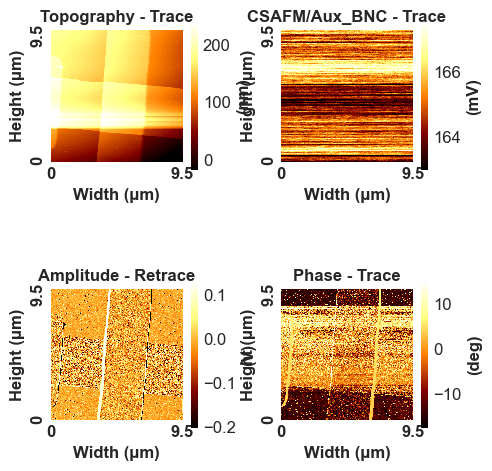

In [70]:
images=loadMI('E5__240703_114329.mi')
AFMPlot(images, figsize=(5, 5))   

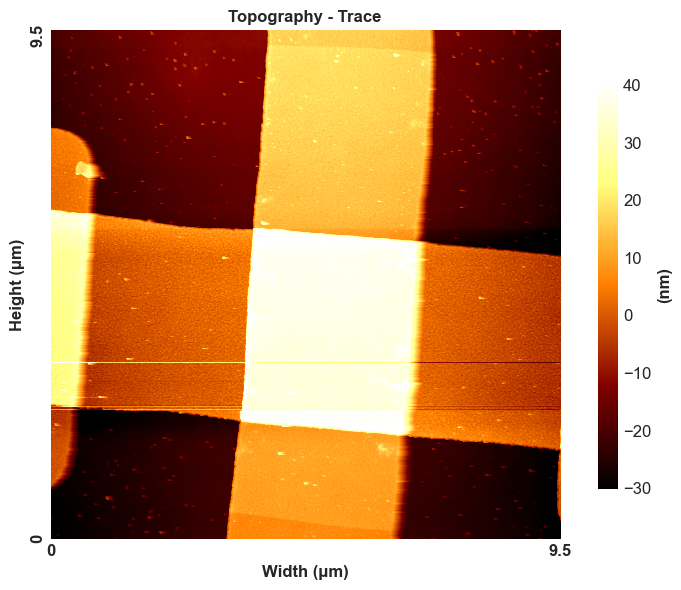

In [ ]:



      
AFMPlot(FlattenImage(FlattenImage(topographyImage,AFMFlatteningMethod.TrimmedMeanOfDifference,trim_ratio=.1), AFMFlatteningMethod.Terrace) )

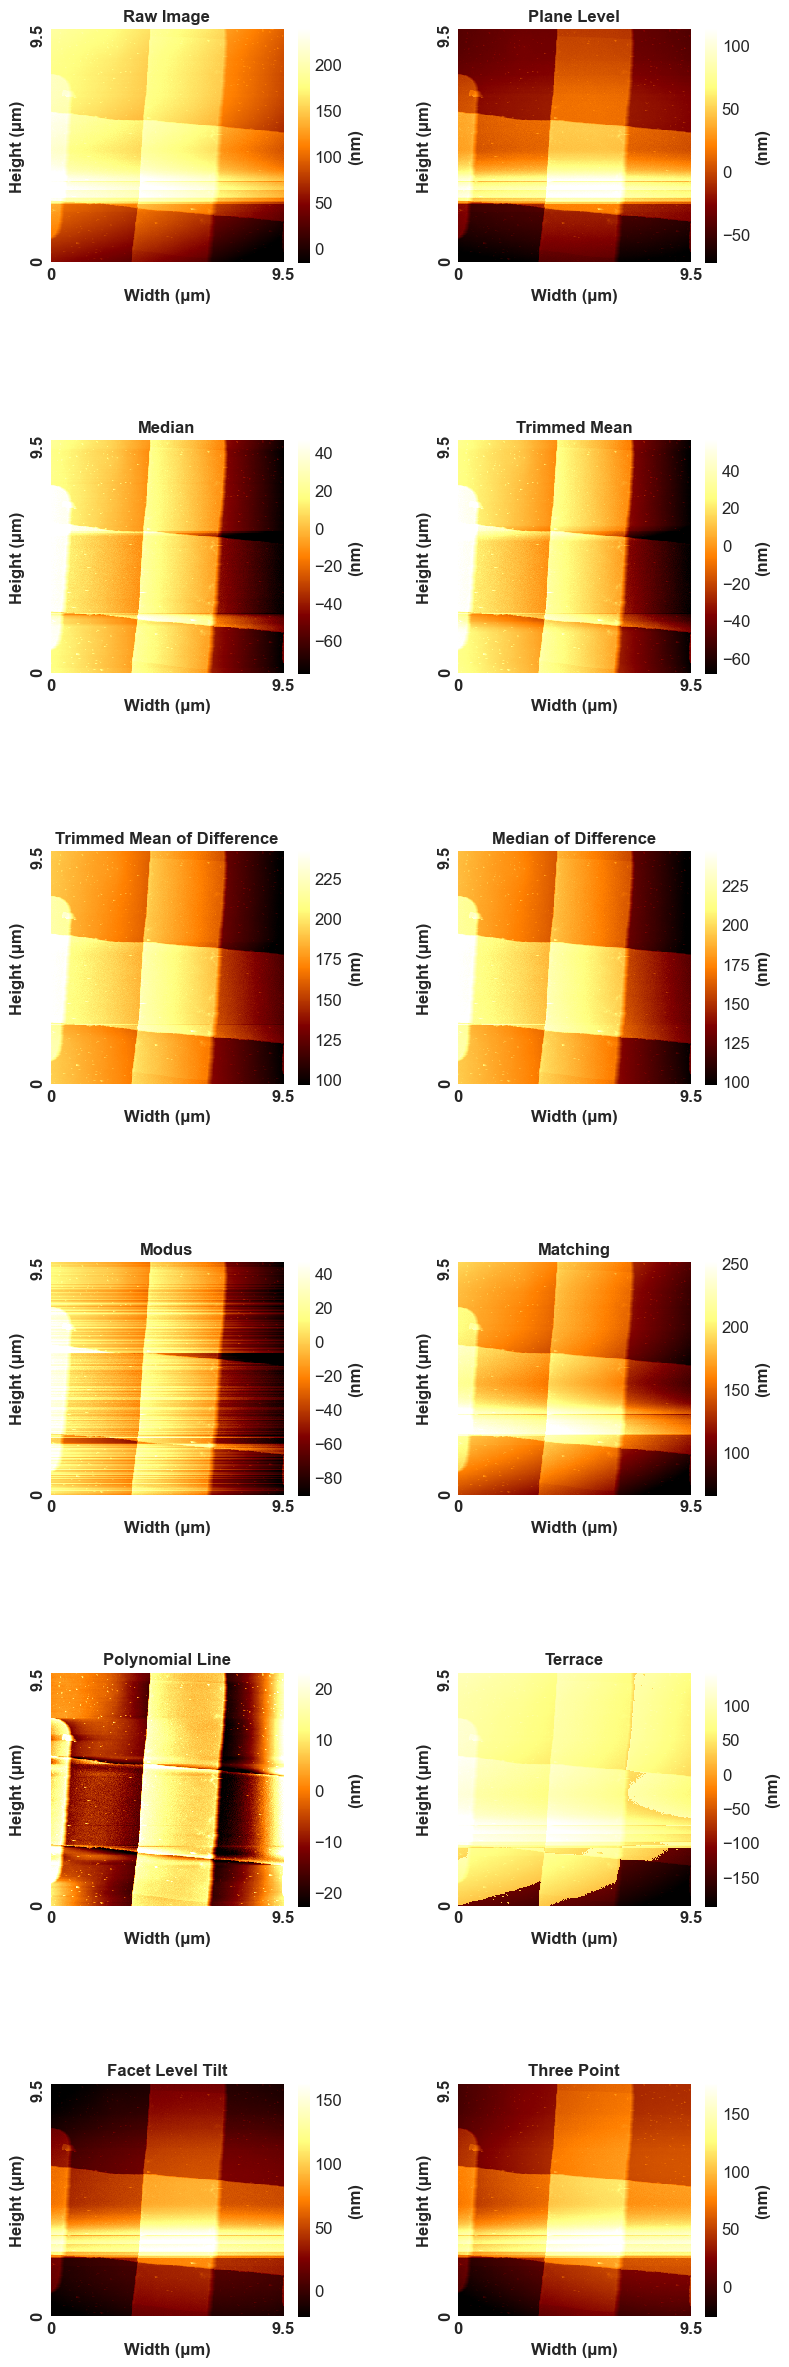

In [71]:
topographyImage= images ['images']['Topography_Trace']
fig, ax = plt.subplots(6, 2,figsize=(8, 6*4))
ax=ax.flatten()
AFMPlot(topographyImage, fig=fig, ax=ax[0], title='Raw Image') 
AFMPlot(FlattenImage(topographyImage, AFMFlatteningMethod.PlaneLevel), fig=fig, ax=ax[1], title='Plane Level')
AFMPlot(FlattenImage(topographyImage, AFMFlatteningMethod.Median), fig=fig, ax=ax[2], title='Median')
AFMPlot(FlattenImage(topographyImage, AFMFlatteningMethod.TrimmedMean), fig=fig, ax=ax[3], title='Trimmed Mean')
AFMPlot(FlattenImage(topographyImage, AFMFlatteningMethod.TrimmedMeanOfDifference,trim_ratio=0.11), fig=fig, ax=ax[4], title='Trimmed Mean of Difference')
AFMPlot(FlattenImage(topographyImage, AFMFlatteningMethod.MedianOfDifference), fig=fig, ax=ax[5], title='Median of Difference')
AFMPlot(FlattenImage(topographyImage, AFMFlatteningMethod.Modus), fig=fig, ax=ax[6], title='Modus')
AFMPlot(FlattenImage(topographyImage, AFMFlatteningMethod.Matching), fig=fig, ax=ax[7], title='Matching')
AFMPlot(FlattenImage(topographyImage, AFMFlatteningMethod.PolynomialLine, degree=3), fig=fig, ax=ax[8], title='Polynomial Line')
AFMPlot(FlattenImage(topographyImage, AFMFlatteningMethod.Terrace), fig=fig, ax=ax[9], title='Terrace')
AFMPlot(FlattenImage(topographyImage, AFMFlatteningMethod.FacetLevelTilt), fig=fig, ax=ax[10], title='Facet Level Tilt')

rows, cols = topographyImage['img'].shape
p1 = (0, 0 )
p2 = (cols-1, 0 )
p3 = (0, rows-1)
    
AFMPlot(FlattenImage(topographyImage, AFMFlatteningMethod.ThreePoint,p1=p1,p2=p2,p3=p3), fig=fig, ax=ax[11], title='Three Point')
fig.tight_layout()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show() 

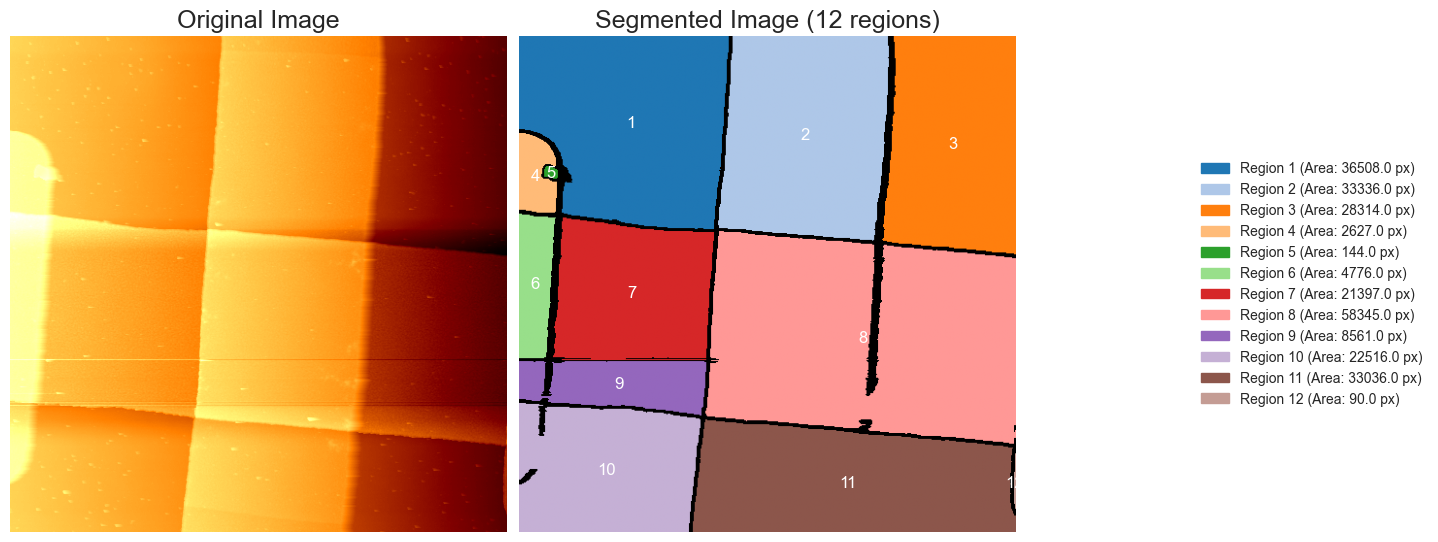

Found 12 regions:
Region 1:
  - Area: 36508.0 pixels
  - Mean height: 0.584567
  - Height range: 0.245384
  - Perimeter: 815.31 pixels

Region 2:
  - Area: 33336.0 pixels
  - Mean height: 0.582852
  - Height range: 0.390648
  - Perimeter: 748.37 pixels

Region 3:
  - Area: 28314.0 pixels
  - Mean height: 0.239173
  - Height range: 0.386829
  - Perimeter: 715.64 pixels

Region 4:
  - Area: 2627.0 pixels
  - Mean height: 0.797826
  - Height range: 0.071163
  - Perimeter: 250.33 pixels

Region 5:
  - Area: 144.0 pixels
  - Mean height: 0.867738
  - Height range: 0.066721
  - Perimeter: 44.73 pixels

Region 6:
  - Area: 4776.0 pixels
  - Mean height: 0.828425
  - Height range: 0.228292
  - Perimeter: 365.15 pixels

Region 7:
  - Area: 21397.0 pixels
  - Mean height: 0.587704
  - Height range: 0.305354
  - Perimeter: 719.78 pixels

Region 8:
  - Area: 58345.0 pixels
  - Mean height: 0.456574
  - Height range: 0.782643
  - Perimeter: 1435.87 pixels

Region 9:
  - Area: 8561.0 pixels
  - Mean

In [56]:
from scipy import ndimage
from skimage import filters, segmentation, color, measure

import matplotlib.patches as mpatches

def segment_afm_image(img, sigma=.10, threshold=0.2, min_size=50):
    """
    Segment an AFM image into regions using Sobel edge detection.
    
    Parameters:
    -----------
    img : numpy.ndarray
        Input AFM image (2D array)
    sigma : float
        Standard deviation for Gaussian filter pre-processing
    threshold : float
        Threshold for edge detection (0.0 to 1.0)
    min_size : int
        Minimum region size in pixels
        
    Returns:
    --------
    dict : Dictionary containing:
        - 'labeled_image': Integer array with labeled regions
        - 'region_masks': List of boolean masks for each region
        - 'region_properties': List of region properties (area, centroid, etc.)
    """
    # Make a copy of the input image
    image = img.copy()
    
    # Normalize image to 0-1 range
    if image.min() != image.max():
        image = (image - image.min()) / (image.max() - image.min())
    
    # Apply Gaussian filter to reduce noise
    smoothed = filters.gaussian(image, sigma=sigma)
    
    # Calculate Sobel gradients
    sobel_h = filters.sobel_h(smoothed)
    sobel_v = filters.sobel_v(smoothed)
    edge_magnitude = np.sqrt(sobel_h**2 + sobel_v**2)
    
    # Threshold the edge magnitude to create binary edge map
    edges = edge_magnitude > threshold * edge_magnitude.max()
    
    # Create segmentation from edges
    segmented = ndimage.binary_fill_holes(~edges)
    
    # Label connected regions
    labeled_image, num_features = ndimage.label(segmented)
    
    # Remove small regions
    region_sizes = np.bincount(labeled_image.ravel())
    mask_sizes = region_sizes >= min_size
    mask_sizes[0] = 0  # Remove background
    cleaned_labels = mask_sizes[labeled_image]
    
    # Relabel regions after cleaning
    labeled_cleaned, num_cleaned = ndimage.label(cleaned_labels)
    
    # Extract region properties
    region_props = measure.regionprops(labeled_cleaned, image)
    
    # Create masks for each region
    region_masks = []
    for i in range(1, num_cleaned + 1):
        region_masks.append(labeled_cleaned == i)
    
    return {
        'labeled_image': labeled_cleaned,
        'region_masks': region_masks,
        'region_properties': region_props
    }

def plot_segmented_image(original_img, segmentation_result, figsize=(12, 10)):
    """
    Plot the original image and its segmentation.
    
    Parameters:
    -----------
    original_img : numpy.ndarray
        Original AFM image
    segmentation_result : dict
        Result from segment_afm_image function
    figsize : tuple
        Figure size
    """
    # Get data from segmentation result
    labeled_image = segmentation_result['labeled_image']
    region_masks = segmentation_result['region_masks']
    region_props = segmentation_result['region_properties']
    
    # Create a color map for visualization
    num_regions = len(region_masks)
    cmap = plt.cm.tab20
    
    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Plot original image
    axes[0].imshow(original_img, cmap='afmhot')
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    # Create colored segmentation image
    colored_label_image = color.label2rgb(labeled_image, bg_label=0, 
                                         colors=[cmap(i % cmap.N) for i in range(num_regions)])
    
    # Plot segmented image
    axes[1].imshow(colored_label_image)
    axes[1].set_title(f'Segmented Image ({num_regions} regions)')
    axes[1].axis('off')
    
    # Add region properties as text
    for i, props in enumerate(region_props):
        centroid = props.centroid
        axes[1].text(centroid[1], centroid[0], f'{i+1}', 
                     color='white', fontsize=12, ha='center', va='center')
    
    # Create legend patches
    handles = []
    for i in range(num_regions):
        patch = mpatches.Patch(color=cmap(i % cmap.N), label=f'Region {i+1} (Area: {region_props[i].area} px)')
        handles.append(patch)
    
    # Add legend
    lgd = fig.legend(handles=handles, loc='center right', 
                     bbox_to_anchor=(1.2, 0.5), fontsize=10)
    
    plt.tight_layout()
    plt.subplots_adjust(right=0.85)
    plt.show()
    
    return fig, axes

# Example usage with the topography image
def analyze_afm_regions(img_dict, sigma=1.0, threshold=0.2, min_size=50):
    """
    Segment and analyze an AFM image, showing region properties.
    
    Parameters:
    -----------
    img_dict : dict
        AFM image dictionary (as produced by loadMI)
    sigma, threshold, min_size : parameters for segment_afm_image
    
    Returns:
    --------
    dict : Dictionary containing segmentation results and analysis
    """
    
    img_dict = FlattenImage(img_dict,AFMFlatteningMethod.TrimmedMean)
    if isinstance(img_dict, dict) and 'img' in img_dict:
        image = img_dict['img']
    else:
        image = img_dict
        
    
        
    # Segment the image
    seg_result = segment_afm_image(image, sigma=sigma, threshold=threshold, min_size=min_size)
    
    # Plot results
    plot_segmented_image(image, seg_result)
    
    # Calculate and print statistics for each region
    print(f"Found {len(seg_result['region_masks'])} regions:")
    region_stats = []
    
    for i, props in enumerate(seg_result['region_properties']):
        region_data = {
            'Region': i+1,
            'Area (px)': props.area,
            'Mean Height': props.mean_intensity,
            'Min Height': props.min_intensity,
            'Max Height': props.max_intensity,
            'Height Range': props.max_intensity - props.min_intensity,
            'Centroid': props.centroid,
            'Perimeter': props.perimeter
        }
        region_stats.append(region_data)
        
        print(f"Region {i+1}:")
        print(f"  - Area: {props.area} pixels")
        print(f"  - Mean height: {props.mean_intensity:.6f}")
        print(f"  - Height range: {props.max_intensity - props.min_intensity:.6f}")
        print(f"  - Perimeter: {props.perimeter:.2f} pixels")
        print()
    
    return {
        'segmentation': seg_result,
        'region_stats': region_stats
    }
    
info=analyze_afm_regions(topographyImage, sigma=1.0, threshold=0.2, min_size=50)
